In [1]:
import sys
sys.path.insert(0, '../train')
from helper import *
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

#Wireless Parameters
N_t = 64
N_r = 16
alpha = 0.4
N_p = int(alpha*N_t)

In [3]:
import copy
H_org_A = sio.loadmat("../../data/H_16x64_MIMO_CDL_A_ULA_test.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_org_B = sio.loadmat("../../data/H_16x64_MIMO_CDL_B_ULA_test.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_org_C = sio.loadmat("../../data/H_16x64_MIMO_CDL_C_ULA_test.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_org_D = sio.loadmat("../../data/H_16x64_MIMO_CDL_D_ULA_test.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_org_E = sio.loadmat("../../data/H_16x64_MIMO_CDL_E_ULA_test.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))
H_ex = np.concatenate([H_ex_A,H_ex_B,H_ex_C,H_ex_D,H_ex_E],axis=2)

N_s = N_r
N_rx_rf = N_r
Nbit_t = 6
Nbit_r = 2
angles_t = np.linspace(0,2*np.pi,2**Nbit_t,endpoint=False)
angles_r = np.linspace(0,2*np.pi,2**Nbit_r,endpoint=False)

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_rx_rf):
    angle_index = np.random.choice(len(angles_r),(N_r,N_rx_rf))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

SNR_vec = range(-15,20,5)
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])
pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
symbols = qpsk_constellation[pilot_sequence_ind]
precoder_training = training_precoder(N_t,N_s)
W = training_combiner(N_r,N_rx_rf)
A = np.kron(np.matmul(symbols.T,precoder_training.T),W)

identity = np.identity(N_r)
A_H = np.matrix(A).getH()
dft_basis = sio.loadmat("../../data/dft_basis.mat")
A1 = dft_basis['A1']/np.sqrt(N_t)
A2 = dft_basis['A2']/np.sqrt(N_r)
A_sp = np.kron(np.matmul(np.matrix(A1).getH(),np.matmul(precoder_training,symbols)).getT(),A2)
A_sp_H = np.matrix(A_sp).getH()

In [4]:
#Mutual Coherence Computation
M_val = 0.0
for i in range(A_sp.shape[1]):
    for j in range(i):
        M_val_new = np.abs(np.dot(np.matrix(A_sp[:,i]).getH(),A_sp[:,j]))/(np.linalg.norm(A_sp[:,i])*np.linalg.norm(A_sp[:,j]))
        M_val = np.maximum(M_val,M_val_new.tolist()[0][0])
print(M_val)

0.6769443804687426


In [ ]:
#Lasso estimation
import cvxpy as cp
M = N_r*N_p
N = N_r*N_t
nrepeat = 5 #Different noise realizations
ntest = 12
t = cp.Variable((N,1))
obj = cp.Minimize(cp.sum(t))
H_v = cp.Variable((2*N,1))
cons = []
A_sp_cp = np.vstack((np.real(A_sp[:,0]),np.imag(A_sp[:,0])))
A_sp_cp = np.hstack((A_sp_cp,np.vstack((-np.imag(A_sp[:,0]),np.real(A_sp[:,0])))))
nmse_lasso = np.zeros((len(SNR_vec),1))
for i in range(1,N):
    A_sp_cp = np.hstack((A_sp_cp,np.vstack((np.real(A_sp[:,i]),np.imag(A_sp[:,i])))))
    A_sp_cp = np.hstack((A_sp_cp,np.vstack((-np.imag(A_sp[:,i]),np.real(A_sp[:,i])))))
for i in range(N):
    cons.append(cp.norm(H_v[2*i:2*(i+1)]) <= t[i])
for i in range(nrepeat):
    for ind in range(ntest):
        vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
        noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r*N_p,1)+1j*np.random.randn(N_r*N_p,1))
        vec_y = np.zeros((N_r*N_p,1,len(SNR_vec)),dtype='complex64')
        for k in range(len(SNR_vec)):
            signal = A*vec_H_single
            E_s = np.multiply(signal,np.conj(signal))
            std_dev = (1/(10**(SNR_vec[k]/20)))*np.sqrt(E_s)
            vec_y[:,:,k] = A*vec_H_single + np.multiply(std_dev,noise_matrix)
            Y = np.vstack((np.real(vec_y[:,:,k]),np.imag(vec_y[:,:,k])))
            prob = cp.Problem(obj,cons+[A_sp_cp@H_v==Y])
            prob.solve(verbose=False)
            H_sparse_ri = H_v.value
            H_sparse = np.reshape(H_sparse_ri[0:2*N:2] + 1j*H_sparse_ri[1:2*N:2],[N_r,N_t],order='F')
            H_lasso = np.matmul(np.matmul(A2,H_sparse),np.matrix(A1).getH())
            nmse_lasso[k] = nmse_lasso[k] + (np.linalg.norm(np.reshape(H_lasso.flatten(order='F'),[N,1]) - vec_H_single)/np.linalg.norm(vec_H_single))**2
nmse_lasso = nmse_lasso/(nrepeat*ntest)

In [11]:
#OMP Estimation
import time
alpha_arr = [0.4]
nrepeat = 20 #Different noise realizations
ntest = 128
hybrid = 1
nmse_omp = np.zeros((len(SNR_vec),ntest))
for i in range(nrepeat):
    for j in range(len(alpha_arr)):
        alpha = alpha_arr[j]
        N_p = int(alpha*N_t) 
        M = N_r*N_p
        if hybrid:
            M = N_s*N_p
        N = N_r*N_t
        if hybrid:
            pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
        else:
            pilot_sequence_ind = np.random.randint(0,4,size=(N_t,N_p))
        pilot_sequence = qpsk_constellation[pilot_sequence_ind]
        A = np.kron(np.matrix(pilot_sequence).getT(),identity)
        if hybrid:
            precoder_training = training_precoder(N_t,N_s)
            W = training_combiner(N_r,N_rx_rf)
            A = np.kron(np.matmul(pilot_sequence.T,precoder_training.T),W)
            A_t = np.kron(np.matmul(pilot_sequence.T,precoder_training.T),identity)
            A_sp = np.kron(np.matmul(np.matrix(A1).getH(),np.matmul(precoder_training,pilot_sequence)).getT(),np.matmul(W,A2))
        else:
            A = np.kron(np.matrix(pilot_sequence).getT(),identity)
            A_sp = np.kron(np.matmul(np.matrix(A1).getH(),np.matrix(pilot_sequence)).getT(),A2)
        for ind in range(0,H_ex.shape[2],2):
            vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
            if hybrid:
                signal = np.matmul(A_t,vec_H_single)
                signal_omp = np.matmul(A,vec_H_single)
                E_s_omp = np.multiply(signal_omp,np.conj(signal_omp))
            else:
                signal = np.matmul(A,vec_H_single)
            E_s = np.multiply(signal,np.conj(signal))
            noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r*N_p,1)+1j*np.random.randn(N_r*N_p,1))
            if hybrid:
                vec_y = np.zeros((N_s*N_p,1,len(SNR_vec)),dtype='complex64')
            else:
                vec_y = np.zeros((N_r*N_p,1,len(SNR_vec)),dtype='complex64')
            for k in range(len(SNR_vec)):
                std_dev = (1/(10**(SNR_vec[k]/20)))*np.sqrt(E_s)
                noise = np.multiply(std_dev,noise_matrix)
                if hybrid:
                    eye_N_p = np.identity(N_p)
                    noise = np.matmul(np.kron(eye_N_p,W),noise)
                vec_y[:,:,k] = np.matmul(A,vec_H_single) + noise
                #From NJ Myers Code
                dum = np.zeros((N_r*N_t,1),dtype='complex128')
                x = dum
                iter = 0
                if hybrid:
                    epsilon = np.sqrt(np.mean(E_s_omp))
                else:
                    epsilon = np.sqrt(np.mean(E_s))
                epsilon *= (1/(10**(SNR_vec[k]/20)))*np.sqrt(A.shape[0])
                cind = []
                while True:
                    res = vec_y[:,:,k] - np.matmul(A_sp,x)
                    alpha = np.argmax(np.abs(np.matmul(A_sp.getH(),res)))
                    cind = np.union1d(cind,alpha)
                    D = [int(x) for x in cind]
                    tmpv = np.matmul(np.linalg.pinv(A_sp[:,D]),vec_y[:,:,k])
                    x = dum
                    x[D] = tmpv
                    cind = D
                    iter = iter + 1
                    if np.linalg.norm(res) <= epsilon or iter == 200:
                        break
                H_omp = np.matmul(np.matmul(A2,np.reshape(x,[N_r,N_t],order='F')),np.matrix(A1).getH())
                print((np.linalg.norm(np.reshape(H_omp.flatten(order='F'),[N,1]) - vec_H_single)/np.linalg.norm(vec_H_single))**2)
                nmse_omp[k,int(ind/2)] = nmse_omp[k,int(ind/2)] + (np.linalg.norm(np.reshape(H_omp.flatten(order='F'),[N,1]) - vec_H_single)/np.linalg.norm(vec_H_single))**2
nmse_omp = nmse_omp/nrepeat       

4.446206429092242
2.475082825719182
1.8267598414165165
1.6030700963161912
1.4846467101480207
1.2491287044216393
1.597214872969598
7.137437777846643
3.1828227578021036
1.2452023929479734
0.9040871456488077
0.8934647496679243
0.8664543253004487
0.8858499971260296
1.4183222530275563
0.8894274884692619
1.0737675015946428
1.1214440108023844
1.372058758326082
1.8801432281566415
1.713962097934869
1.618336546087091
1.4878892942556476
1.183402533068332
0.7968889974254989
0.8705138729321098
0.9106620834301854
0.8947108185000385
3.8514470385552233
1.7749142239097722
1.537261755500266
1.2656157412215165
0.7913427948409095
1.4549204597422474
1.3552913242079352
3.5231048576547863
1.991906926642603
1.2671031514516382
1.1229711330932401
0.8397915616315077
1.2196659012728184
1.2961145877129197
3.095153955834845
1.9148230694989992
1.8101391989546018
1.9127471345446263
0.9351940714647682
1.1815994208820206
1.098104345663695
1.4915099406254275
1.1900486380656918
0.9957998191655687
1.0706577756806546
0.951

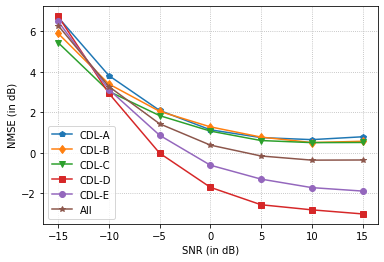

In [12]:
nmse_ABCDE = np.zeros((5,len(SNR_vec)))
nmse_ABCDE[0,:] = np.mean(nmse_omp[:,0:26],axis=1)
nmse_ABCDE[1,:] = np.mean(nmse_omp[:,26:51],axis=1)
nmse_ABCDE[2,:] = np.mean(nmse_omp[:,51:77],axis=1)
nmse_ABCDE[3,:] = np.mean(nmse_omp[:,77:104],axis=1)
nmse_ABCDE[4,:] = np.mean(nmse_omp[:,104:],axis=1)
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[0,:]),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[1,:]),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[2,:]),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[3,:]),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_ABCDE[4,:]),'o-',label='CDL-E')
plt.plot(SNR_vec,10*np.log10(np.mean(nmse_omp,axis=1)),'*-',label='All')
plt.legend()
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')
plt.legend(loc='lower left')
plt.show()